# Flood Routing
Diberikan data hidrograf inflow dan outflow, hitunglah konstanta fungsi simpanan (storage function) Metode Muskingum (K dan x). 

Dengan data inflow yang lain, hitunglah hidrograf outflow menggunakan K dan x yang sudah diperoleh dari aktivitas di atas

Gunakan data yang diberikan pada program ini, dan data yang diberikan pada tugas perhitungan manual (di perkuliahan)

Variable Names :  ['time', 'Inflow', 'Outflow']
Data :  [[ 0.  5.  5.]
 [ 6. 20.  6.]
 [12. 50. 12.]
 [18. 50. 29.]
 [24. 32. 38.]
 [30. 22. 35.]
 [36. 15. 29.]
 [42. 10. 23.]
 [48.  7. 17.]
 [54.  5. 13.]
 [60.  5.  9.]
 [66.  5.  7.]]
K dan x :  13.33 dan 0.20


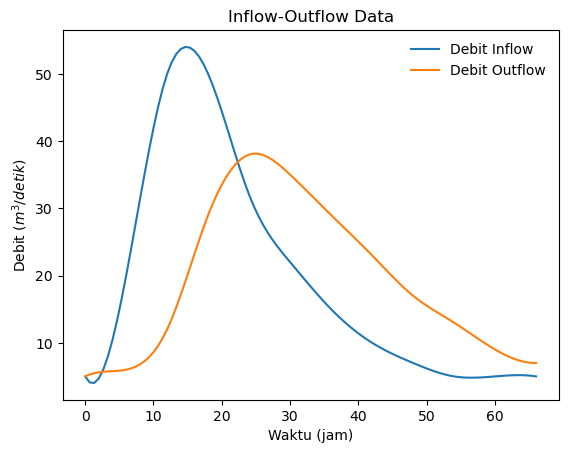

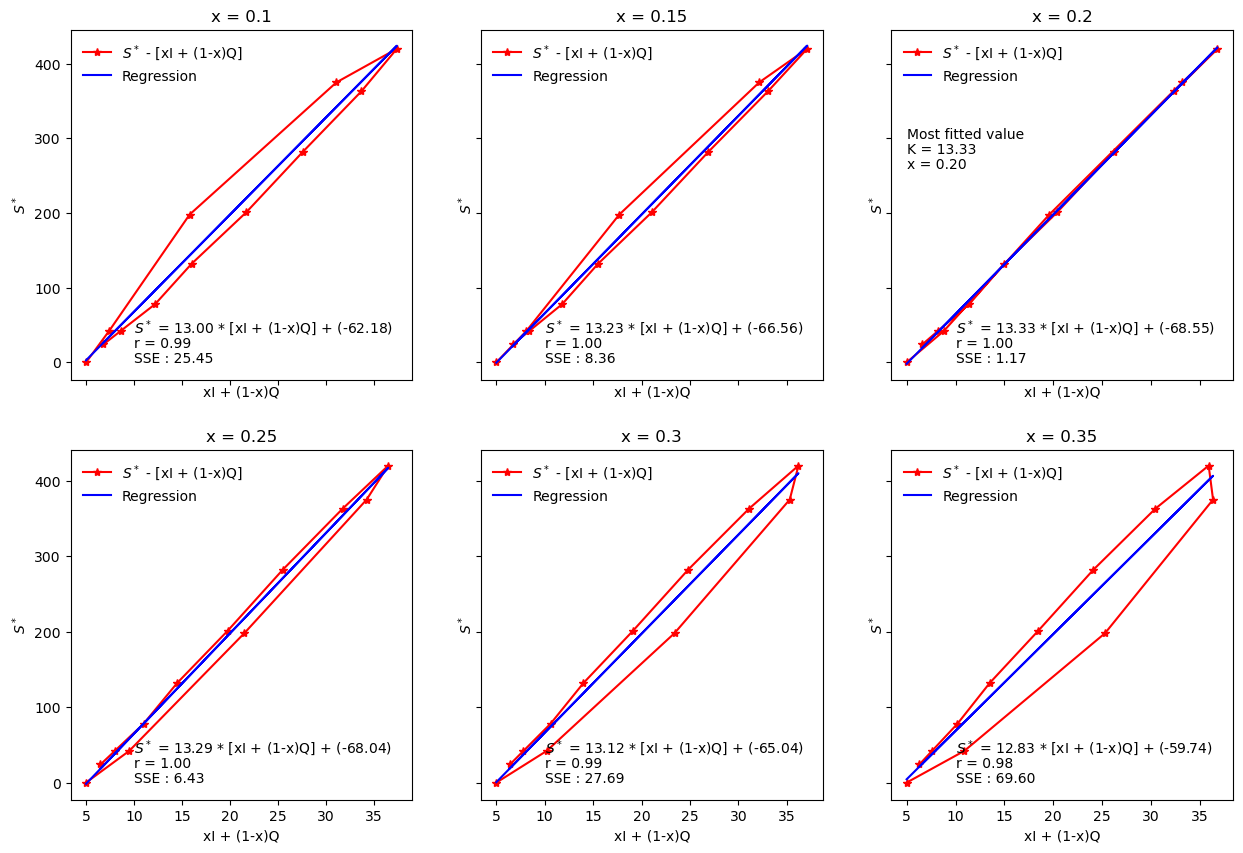

Variable Names :  ['time', 'Inflow']
Data :  [[ 0.  5.]
 [ 6. 15.]
 [12. 45.]
 [18. 45.]
 [24. 28.]
 [30. 17.]
 [36. 10.]
 [42.  8.]
 [48.  7.]
 [54.  5.]
 [60.  5.]
 [66.  5.]]


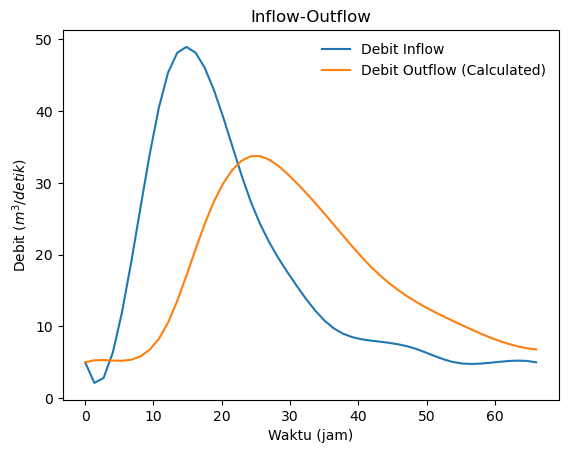

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats

import rd_csv as rd

# name of file to read data and save output file
nameString= 'in-outData'
fileName1 = nameString+'.csv'
figName1  = nameString+'.png'
figName2 = nameString+'_Muskingum.png'
rd.read_csv(fileName1) #column name become variable name : time, Inflow, Outflow

#cubic spline interpolation for input variables
from scipy import interpolate as intr
interpolate_Inflow = intr.splrep(rd.time, rd.Inflow, s = 0)
interpolate_Outflow = intr.splrep(rd.time, rd.Outflow, s = 0)
time_new = np.linspace(rd.time.min(), rd.time.max(), 100) 
newInflow = intr.splev(time_new, interpolate_Inflow, der = 0)
newOutflow = intr.splev(time_new, interpolate_Outflow, der = 0)
# Plot inflow and outflow discharge
fig1, ax = plt.subplots(1, 1) #, sharex='col', sharey='row')
ax.plot(time_new, newInflow, label='Debit Inflow')
ax.plot(time_new, newOutflow, label='Debit Outflow')
ax.set_title('Inflow-Outflow Data')
ax.set_xlabel('Waktu (jam)')
ax.set_ylabel('Debit ($m^3/detik$)')
ax.legend(loc='upper right', shadow=False, frameon=False)
fig1.savefig(figName1)

# calculate actual channel storage
n = len(rd.time)
dSdt = np.zeros(n)
dS  = np.zeros(n)
S  = np.zeros(n)
dt = rd.time[1] - rd.time[0]

dSdt[0] = 0 
dSdt[1:n+1] = (rd.Inflow[0:n-1] + rd.Inflow[1:n+1])/2 - (rd.Outflow[0:n-1] + rd.Outflow[1:n+1])/2
#print ('dSdt : ',dSdt)

dS[0:n+1] = dSdt[0:n+1] * dt
#print ('dS : ',dS)

S[0] = rd.Inflow[0] - rd.Outflow[0]
for i in range(1,n):
    S[i] = S[i-1] + dS[i]

#print ('S : ',S)

def Muskingum(x, I, Q):
    Musk = x*I + (1-x)*Q
    return Musk

def c123(K, x, dt):
    denom = 2*K*(1-x)+dt
    c1 = (dt-2*K*x)/denom
    c2 = (dt+2*K*x)/denom
    c3 = (2*K*(1-x)-dt)/denom
    return c1, c2, c3

def QoutCalc(c1, c2, c3, I):
    Qout = np.zeros(n)
    Qout[0] = I[0]
    for i in range(1,n):
        Qout[i] = c1*I[i] + c2*I[i-1] + c3*Qout[i-1]
    return Qout

x = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
Musk_Term = {}
outflowCalc = {}
sseOutflow = {}
# plot each Muskngum Term with S
fig2, ax = plt.subplots(2, 3, figsize = (15,10), sharex='col', sharey='row')
dummy_sse2 = dummy_sse1 = 0
for i in x:
    Musk_Term[i] = Muskingum(i, rd.Inflow, rd.Outflow)
    slope, intercept, r_value, p_value, std_err = stats.linregress(Musk_Term[i], S) #linear regression
    line = slope*(Musk_Term[i])+intercept    

    #calculate theoretical outflow
    c1, c2, c3 = c123(slope, i, dt)
    outflowCalc[i] = QoutCalc(c1, c2, c3, rd.Inflow)
    dummy_sse2 = dummy_sse1
    sseOutflow[i] = np.square(outflowCalc[i] - rd.Outflow).sum()
    dummy_sse1 = sseOutflow[i]
    if (dummy_sse1<dummy_sse2):
        K = slope; x = i
    #positioning graph using p and q
    if (i<0.25):
        p = 0; q = math.ceil((i-0.1)/0.05); 
    else:
        p = 1; q = math.ceil((i-0.25)/0.05)

    ax[p,q].plot(Musk_Term[i], S, 'r*-', label='$S^*$ - [xI + (1-x)Q]')
    ax[p,q].plot(Musk_Term[i], line, 'b-', label='Regression')
    ax[p,q].text(10, 40, '$S^*$ = '+ format(slope, '.2f') +' * [xI + (1-x)Q] '+'+ ('+format(intercept, '.2f')+')')
    ax[p,q].text(10, 20, 'r = '+format(r_value, '.2f'))
    ax[p,q].text(10, 0, 'SSE : '+format(sseOutflow[i], '.2f'))
    ax[p,q].set_title('x = '+ str(i))
    ax[p,q].set_xlabel('xI + (1-x)Q')
    ax[p,q].set_ylabel('$S^*$')
    ax[p,q].legend(loc='upper left', shadow=False, frameon=False)

print ('K dan x : ', format(K, '.2f') +' dan '+ format(x, '.2f'))
if (x<0.25):
    p = 0; q = math.ceil((x-0.1)/0.05); 
else:
    p = 1; q = math.ceil((x-0.25)/0.05)
ax[p,q].text(5, 300, 'Most fitted value')
ax[p,q].text(5, 280, 'K = '+format(K, '.2f'))
ax[p,q].text(5, 260, 'x = '+format(x, '.2f'))
fig2.savefig(figName2)
plt.show()

if __name__ == "__main__": #make this module can be run independently for routing testing with new inflow data
    # set new inflow data for outflow calculation
    fileNameIn = 'inData.csv'
    figName3 = 'inData.png'
    rd.read_csv(fileNameIn) #column name become variable name : time, Inflow
    n = len(rd.time)

    c1, c2, c3 = c123(K, x, dt)
    outResult = QoutCalc(c1, c2, c3, rd.Inflow)

    #cubic spline interpolation for input variables
    interpolate_Inflow = intr.splrep(rd.time, rd.Inflow, s = 0)
    interpolate_Outflow = intr.splrep(rd.time, outResult, s = 0)
    time_new = np.linspace(rd.time.min(), rd.time.max(), 50) 
    newInflow = intr.splev(time_new, interpolate_Inflow, der = 0)
    newOutflow = intr.splev(time_new, interpolate_Outflow, der = 0)
    # Plot inflow and outflow discharge
    fig3, ax = plt.subplots(1, 1) #, sharex='col', sharey='row')
    ax.plot(time_new, newInflow, label='Debit Inflow')
    ax.plot(time_new, newOutflow, label='Debit Outflow (Calculated)')
    ax.set_title('Inflow-Outflow')
    ax.set_xlabel('Waktu (jam)')
    ax.set_ylabel('Debit ($m^3/detik$)')
    ax.legend(loc='upper right', shadow=False, frameon=False)
    fig3.savefig(figName3)
    plt.show()

    # Save to file
    # Procedure to save unit hydrograph to file
    fileNameOut = 'outData.csv'
    with open(fileNameOut, 'a') as f:
        f.seek(0)                                                       # find first line
        f.truncate()                                                    # delete all data below
        f.write('time, Inflow, Outflow \n')
        for i in range(n):
            wrt_InOut = str(rd.time[i])+','+str(rd.Inflow[i])+','+str(outResult[i])
            f.write(wrt_InOut+'\n')